In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torch_geometric.nn import GCNConv

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch_geometric.data import Data

# Data preparation

In [29]:
class ImageGraphDataset(Dataset):
    def __init__(self, image_dir, graph_data, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            graph_data (list of tuples): List of tuples where each tuple contains:
                                         (node_features, edge_index)
            transform (callable, optional): Optional transform to be applied
                                            on an image sample.
        """
        self.image_dir = image_dir
        self.graph_data = graph_data  # List of (node_features, edge_index)
        self.image_filenames = sorted(os.listdir(image_dir))  # List of image filenames
        self.transform = transform

    def __len__(self):
        # Return the minimum length of image files and graph data
        return min(len(self.image_filenames), len(self.graph_data))

    def __getitem__(self, idx):
        # Load the image
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Load the corresponding graph data
        node_features, edge_index = self.graph_data[idx]
        
        # Convert graph data to tensors
        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long)

        # Return image and graph data
        return image, node_features, edge_index


In [30]:
# Example graph data (replace with real data)
# List of (node_features, edge_index) for each graph
graph_data = [
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64))),  # Example graph 1
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64))),  # Example graph 2
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64))),  # Example graph 3
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64)))   # Example graph 4
]

# Image preprocessing (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize dataset
dataset = ImageGraphDataset(image_dir='data_smiles/Testing_Group/Hepatotoxicity', graph_data=graph_data, transform=transform)

# Initialize DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

C:\Users\predator\AppData\Local\Temp\ipykernel_20236\2239017323.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(node_features, dtype=torch.float)
C:\Users\predator\AppData\Local\Temp\ipykernel_20236\2239017323.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)


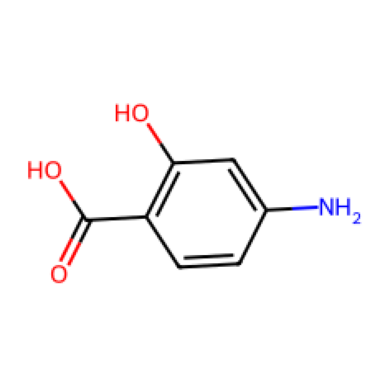

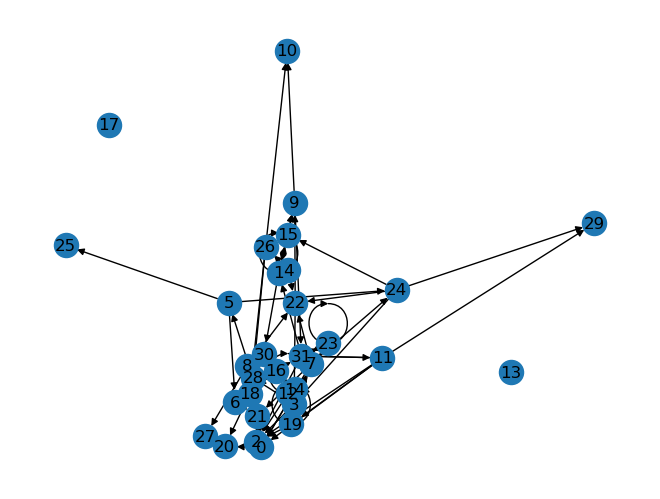

In [32]:
# plot the first image and graph data
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Get the first image and graph data
image, node_features, edge_index = dataset[0]

# Plot the image
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# Plot the graph
G = to_networkx(Data(x=node_features, edge_index=edge_index))
nx.draw(G, with_labels=True)
plt.show()


# Modeling

In [3]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        # Use ResNet18 for image feature extraction
        self.resnet = resnet18(pretrained=True)
        # Remove the final classification layer
        self.resnet.fc = nn.Identity()
        
    def forward(self, x):
        # Extract image features
        return self.resnet(x)

In [4]:
class GCNFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNFeatureExtractor, self).__init__()
        # Two-layer GCN for graph feature extraction
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # First graph convolution + activation
        x = F.relu(self.conv1(x, edge_index))
        # Second graph convolution
        x = self.conv2(x, edge_index)
        return x


In [7]:
class CombinedModel(nn.Module):
    def __init__(self, gcn_input_dim, gcn_hidden_dim, gcn_output_dim, num_classes):
        super(CombinedModel, self).__init__()
        # Image feature extractor
        self.image_extractor = ImageFeatureExtractor()
        # GCN for graph feature extraction
        self.gcn_extractor = GCNFeatureExtractor(gcn_input_dim, gcn_hidden_dim, gcn_output_dim)
        # Fully connected layer for combining features
        self.fc = nn.Linear(512 + gcn_output_dim, num_classes)  # 512 from ResNet18's feature size
        
    def forward(self, image, graph_x, edge_index):
        # Extract features from image
        image_features = self.image_extractor(image)  # shape: (batch_size, 512)
        
        # Extract features from graph
        graph_features = self.gcn_extractor(graph_x, edge_index)  # shape: (batch_size, num_nodes, gcn_output_dim)
        
        # Aggregate graph features (mean over nodes)
        graph_features = graph_features.mean(dim=1)  # shape: (batch_size, gcn_output_dim)
        
        # Combine both features (concatenation)
        combined_features = torch.cat([image_features, graph_features], dim=1)  # shape: (batch_size, 512 + gcn_output_dim)
        
        # Final classification
        output = self.fc(combined_features)
        return output

In [8]:
# Example image input (batch_size, channels, height, width)
image = torch.randn(4, 3, 224, 224)  # batch of 4 RGB images
# Example graph input (batch_size, num_nodes, node_features)
graph_x = torch.randn(4, 32, 128)  # batch of 4 graphs, 32 nodes, 128 features per node
# Example edge indices (connectivity in COO format)
edge_index = torch.randint(0, 32, (2, 64))  # 64 edges

# Initialize combined model
model = CombinedModel(gcn_input_dim=128, gcn_hidden_dim=64, gcn_output_dim=256, num_classes=2)

# Forward pass through the model
output = model(image, graph_x, edge_index)
print(output.shape)  # Output: (batch_size, num_classes)

torch.Size([4, 2])
